### Тестирование алгоритмов классификации, подбор параметров и сравнение качества

### Загрузка и подготовка данных

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [3]:
data = load_digits()

In [4]:
X, y = data['data'], data['target']

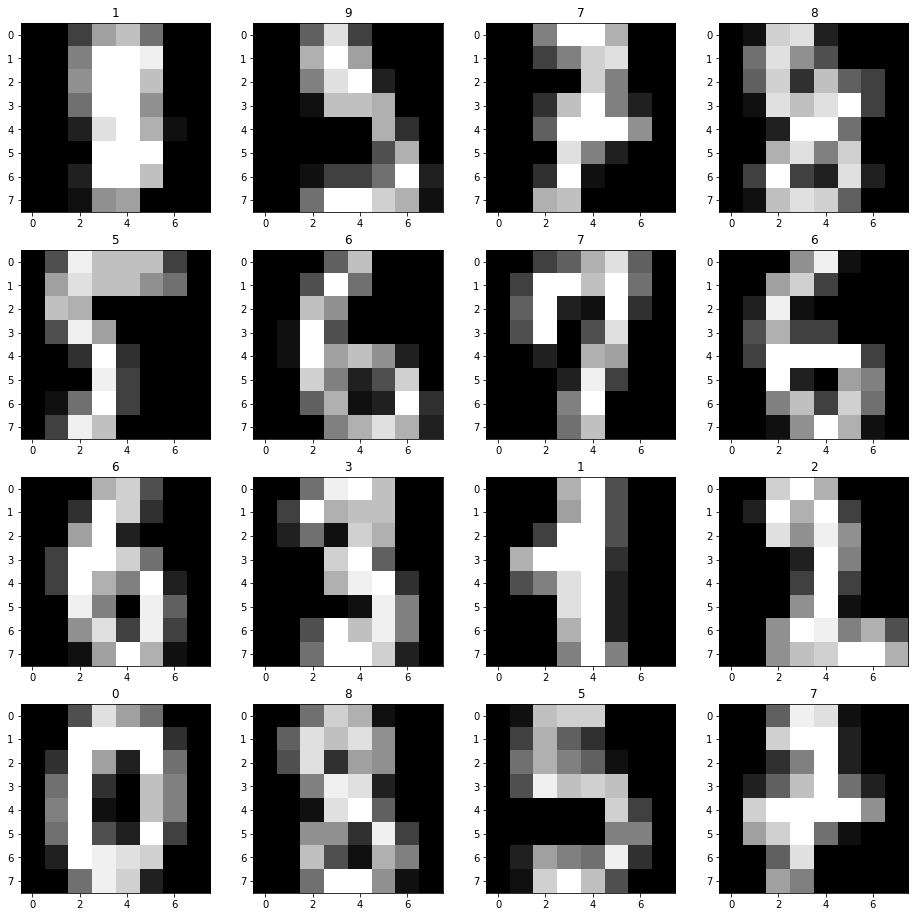

In [5]:
fig = plt.figure(figsize=(16,16))
for i in range(0, 4):
    for j in range(0,4):
        img = np.random.choice(len(X))
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(X[img].reshape(8, 8), cmap='gray')
        plt.title(y[img])
        
plt.show()


###### Разделение датасета на обучающую выборки и выборку для финальной валидации

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

###### Разделение обучающей выборки на обучение и тест

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

### Обучение
Подбор параметров + оценка точности (по метрике accuracy)

###### SGDClassifier

In [88]:
from sklearn.linear_model import SGDClassifier

SGD_cl = SGDClassifier(n_jobs=-1)

grid_param = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'max_iter': [500, 1000, 1500, 2000],
    'penalty': ['l2', 'l1']
}

gs_sgd = GridSearchCV(estimator=SGD_cl,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1)

gs_sgd.fit(X_train, y_train)
gs_sgd.best_params_

{'loss': 'hinge', 'max_iter': 1500, 'penalty': 'l1'}

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, gs_sgd.best_estimator_.predict(X_test))

0.9618055555555556

###### KNeighborsClassifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

KNC = KNeighborsClassifier(n_jobs=-1)

grid_param = {
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['kd_tree', 'ball_tree', 'brute'],
    'n_neighbors': [3,5,7,10,20],
    'weights': ['uniform','distance']
}

gs_knc = GridSearchCV(estimator=KNC,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1)

gs_knc.fit(X_train, y_train)
gs_knc.best_params_

{'algorithm': 'kd_tree',
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'distance'}

In [45]:
accuracy_score(y_test, gs_knc.best_estimator_.predict(X_test))

0.9791666666666666

###### GradientBoostingClassifier

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

GB_cl = GradientBoostingClassifier()

grid_param = {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [50,300],
    #'criterion': ['friedman_mse','mse','mae'],
    'max_depth': [3,40]
}

rs_gb = RandomizedSearchCV(estimator=GB_cl,
                     param_distributions=grid_param, # Проверяем гиперпарметры
                     cv=5)

rs_gb.fit(X_train, y_train)
rs_gb.best_params_

{'n_estimators': 300, 'max_depth': 3, 'loss': 'deviance'}

In [57]:
accuracy_score(y_test, rs_gb.predict(X_test))

0.9444444444444444

###### DecisionTreeClassifier

In [77]:
from sklearn.tree import DecisionTreeClassifier

dtc_cl=DecisionTreeClassifier()

grid_param = {
    'max_depth': [10, 20, 50],
    'max_features': [20, 50, 100],
    'max_leaf_nodes': [50, 100, 200, 300],
    'min_samples_leaf': [5,25,50]
}

gd_dtc = GridSearchCV(estimator=dtc_cl,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1
                    )

gd_dtc.fit(X_train, y_train)
gd_dtc.best_params_

{'max_depth': 10,
 'max_features': 50,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 5}

In [78]:
accuracy_score(y_test, gd_dtc.best_estimator_.predict(X_test))

0.8645833333333334

##### Наиболее высокий уровень точности показал метод K ближайших соседей (Accuracy=97%). Дополнительно максимизировать качество можно через голосование сформированных алгоритмов

In [79]:
from sklearn.ensemble import VotingClassifier

V_cl = VotingClassifier(estimators=[('SGD', gs_sgd),('KNC', gs_knc),
                                      ('GB_cl', rs_gb),('DTC_cl', gd_dtc.best_estimator_)], n_jobs=-1)
V_cl.fit(X_train, y_train)
accuracy_score(y_test, V_cl.predict(X_test))

0.9826388888888888

In [84]:
print('Финальный результат на отложенной выборке: {:.2f}'.format(accuracy_score(y_valid, gs_sgd.predict(X_valid))))

Финальный результат на отложенной выборке: 0.96
